In [44]:
!git clone https://github.com/rslim087a/track

fatal: destination path 'track' already exists and is not an empty directory.


In [45]:
!ls track

driving_log.csv  IMG


In [46]:
import numpy as np,pandas as pd,pickle,matplotlib.pyplot as plt,keras,random,os,ntpath
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D,Dropout,Dense,MaxPooling2D,Flatten
from sklearn.utils import shuffle

In [47]:
np.random.seed(0)

In [48]:
dataDir='track'
cols=['center','left','right','steering','throttle','reverse','speed']
df=pd.read_csv(os.path.join(dataDir,'driving_log.csv'),names=cols)
df.head()

,center,left,right,steering,throttle,reverse,speed
0,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.649786
1,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.627942
2,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.622910
3,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.619162
4,C:\Users\Amer\Desktop\new_track\IMG\center_201...,C:\Users\Amer\Desktop\new_track\IMG\left_2018_...,C:\Users\Amer\Desktop\new_track\IMG\right_2018...,0.0,0.0,0.0,0.615438


In [49]:
def tail_alone(path):
  head,tail=ntpath.split(path)
  return tail

In [50]:
df['center']=df['center'].apply(tail_alone)
df['left']=df['left'].apply(tail_alone)
df['right']=df['right'].apply(tail_alone)

In [51]:
df.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2018_07_16_17_11_43_382.jpg,left_2018_07_16_17_11_43_382.jpg,right_2018_07_16_17_11_43_382.jpg,0.0,0.0,0.0,0.649786
1,center_2018_07_16_17_11_43_670.jpg,left_2018_07_16_17_11_43_670.jpg,right_2018_07_16_17_11_43_670.jpg,0.0,0.0,0.0,0.627942
2,center_2018_07_16_17_11_43_724.jpg,left_2018_07_16_17_11_43_724.jpg,right_2018_07_16_17_11_43_724.jpg,0.0,0.0,0.0,0.622910
3,center_2018_07_16_17_11_43_792.jpg,left_2018_07_16_17_11_43_792.jpg,right_2018_07_16_17_11_43_792.jpg,0.0,0.0,0.0,0.619162
4,center_2018_07_16_17_11_43_860.jpg,left_2018_07_16_17_11_43_860.jpg,right_2018_07_16_17_11_43_860.jpg,0.0,0.0,0.0,0.615438


bins =  [-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]
hist =  [  35    6    6    6   13    8   24   22   53  131   99  158 2990  137
   86  126   54   22   19    2    9    4    4    6   33]


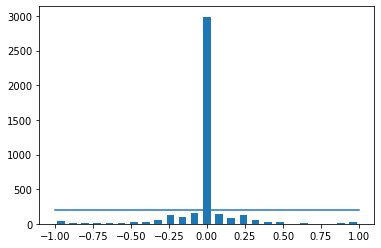

In [52]:
num_bins=25
samples_per_bin=200
hist,bins=np.histogram(df['steering'],num_bins)
print('bins = ',bins)
print('hist = ',hist)
center=(bins[:-1]+bins[1:])/2

plt.bar(center,hist,width=.05)
plt.plot((np.min(df['steering']),np.max(df['steering'])),(samples_per_bin,samples_per_bin))

* if we train cnn with the above data the model will be biased towards driving straight, so preprocessing is done below

In [53]:
print(bins)

[-1.   -0.92 -0.84 -0.76 -0.68 -0.6  -0.52 -0.44 -0.36 -0.28 -0.2  -0.12
 -0.04  0.04  0.12  0.2   0.28  0.36  0.44  0.52  0.6   0.68  0.76  0.84
  0.92  1.  ]


A steering angle will belong to bin[j] if it lies btw
bin[j] and bin[j+1]

ex: steering angle=0.58 then it lies btw  
0.52 <sangle < 0.6  
so sangle belongs to the bin 0.52

In [54]:
remove_list=[]
for j in range(num_bins):
  list_=[]  
  for i in range(len(df['steering'])):    
    if(bins[j]<=df['steering'][i]<=bins[j+1]):
      list_.append(i)
      #this list contains index of all sangles that belong to the bin[j]
  list_=shuffle(list_)
  list_=list_[samples_per_bin:]
  remove_list.extend(list_)

In [55]:
print('Total: ',len(df['steering']))
print('To be Removed: ',len(remove_list))
print('Remaining: ',len(df)-len(remove_list))

Total:  4053
To be Removed:  2790
Remaining:  1263


In [56]:
print(df.index[remove_list])

Int64Index([1495, 1852, 1472, 2024, 3072, 1508, 1653, 3133, 3545, 4000,
            ...
             837,  270, 1649, 3156, 3416,  172, 1693, 1029,  459, 3951],
           dtype='int64', length=2790)


In [57]:
df.drop(df.index[remove_list],inplace=True)

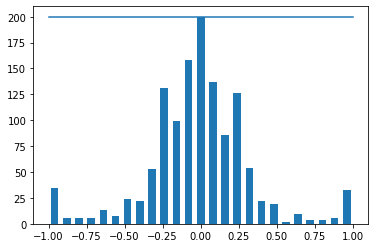

In [58]:
hist,_=np.histogram(df['steering'],num_bins)
plt.bar(center,hist,width=.05)
plt.plot((np.min(df['steering']),np.max(df['steering'])),(samples_per_bin,samples_per_bin))

In [59]:
print(df.iloc[0])

center      center_2018_07_16_17_11_43_670.jpg
left          left_2018_07_16_17_11_43_670.jpg
right        right_2018_07_16_17_11_43_670.jpg
steering                                     0
throttle                                     0
reverse                                      0
speed                                 0.627942
Name: 1, dtype: object


In [60]:
dummy=[]
dummy.append(os.path.join('track','dummy.jpg'))
print(np.asarray(dummy))


['track/dummy.jpg']


In [61]:
def load_img_steering(dataDir,df):
  image_path=[]   #->a list not an array
  steering=[]
  for i in range(len(df)):
    rowData=df.iloc[i]
    center,left,right=rowData[0],rowData[1],rowData[2]
    image_path.append(os.path.join(dataDir,center.strip()))
    steering.append(float(rowData[3]))
  image_paths=np.asarray(image_path)
  steerings=np.asarray(steering)
  return image_paths,steerings

In [62]:
image_paths,steerings=load_img_steering(dataDir+'/IMG',df)

In [63]:
from sklearn.model_selection import train_test_split as tts

In [64]:
X_train, X_test, y_train, y_test = tts(image_paths,steerings, test_size=0.2, random_state=6)
print('Train data len= ',len(X_train),' train labels length = ',len(y_train))
print('Test data len= ',len(X_test),' test labels length = ',len(y_test))

Train data len=  1010  train labels length =  1010
Test data len=  253  test labels length =  253


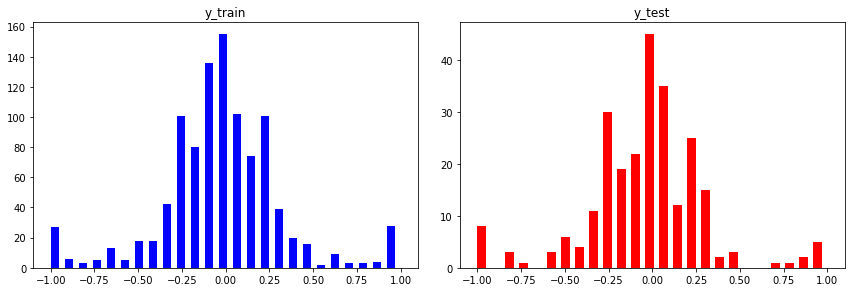

In [65]:
fig,axes=plt.subplots(nrows=1,ncols=2,figsize=(12,4))
plt.tight_layout()
axes[0].hist(y_train,num_bins,width=.05,color='blue')
axes[0].set_title('y_train')
axes[1].hist(y_test,num_bins,width=0.05,color='red')
axes[1].set_title('y_test')
plt.show()

In [66]:
import matplotlib.image as npimg
import cv2

In [67]:
def img_process(img):
  img=npimg.imread(img)
  img=img[60:135,:,:]
  img=cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
  img=cv2.GaussianBlur(img,(3,3),0)
  img=cv2.resize(img,(200,66))
  img=img/255    #normalization
  return img

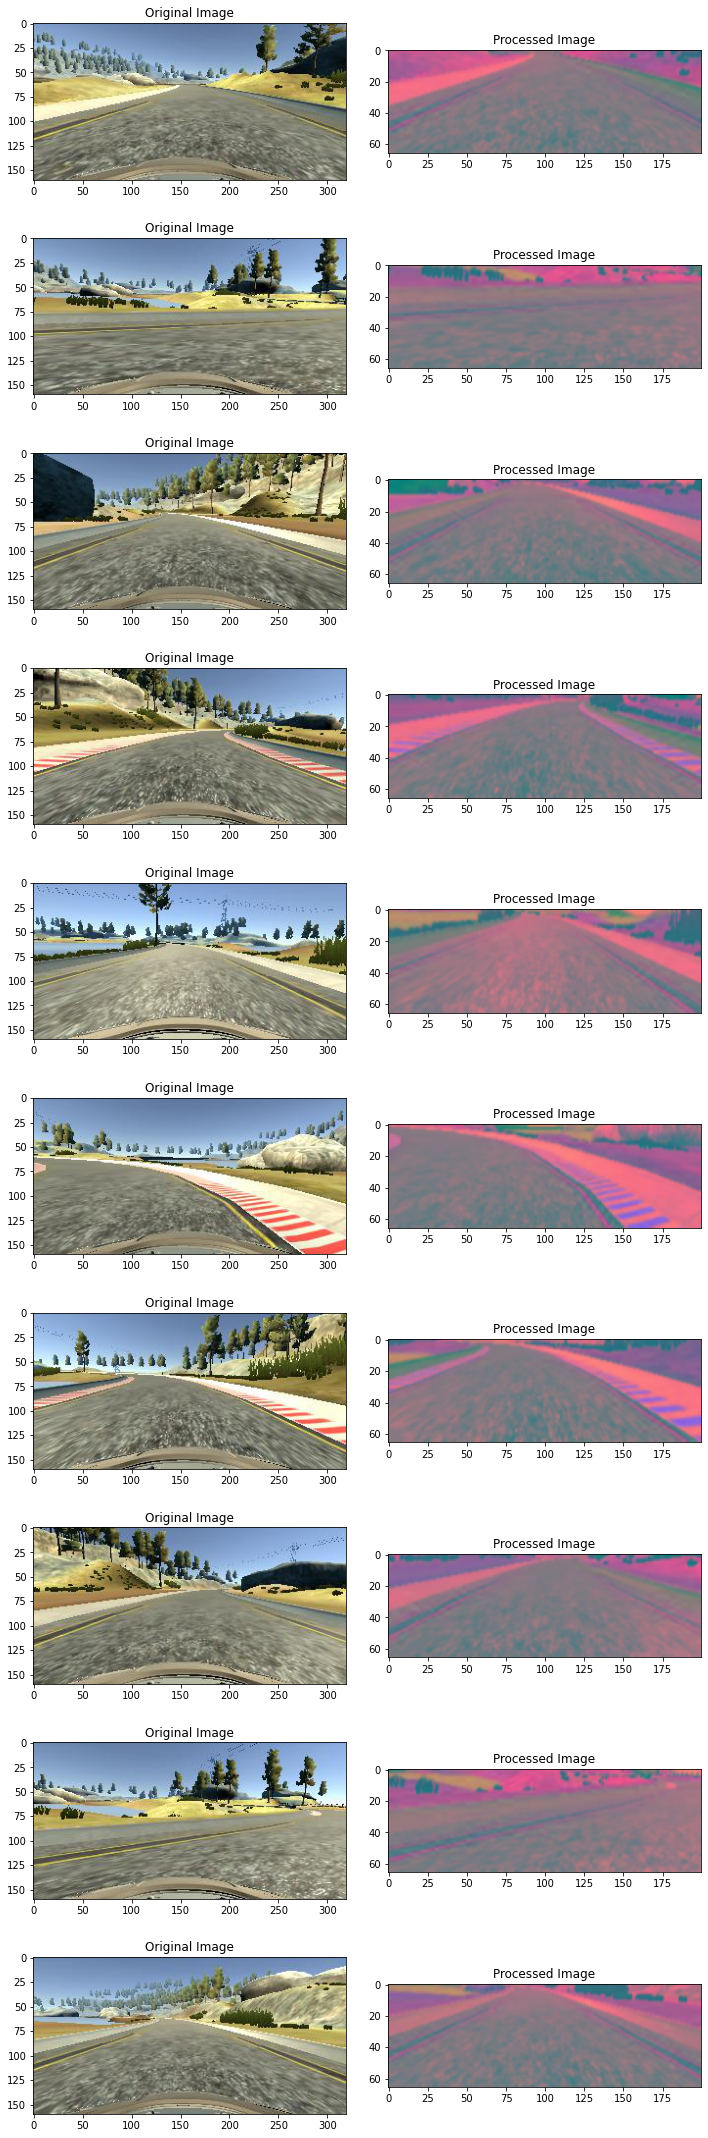

In [68]:
fig,axes=plt.subplots(10,2,figsize=(10,30))
fig.tight_layout()
for i in range(10):
  img=image_paths[np.random.randint(0,len(image_paths)-1)]
  original_img=npimg.imread(img)
  processed_img=img_process(img)
  axes[i][0].imshow(original_img)
  axes[i][0].set_title('Original Image')
  axes[i][1].imshow(processed_img)
  axes[i][1].set_title('Processed Image')

plt.show()

In [69]:
X_train=np.array(list(map(img_process,X_train)))
X_test=np.array(list(map(img_process,X_test)))

# Checking if everything is pre-processed

(1010, 66, 200, 3)


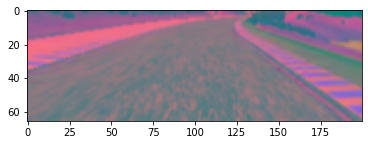

In [70]:
plt.imshow(X_train[np.random.randint(0,len(X_train)-1)])
print(X_train.shape)

(253, 66, 200, 3)


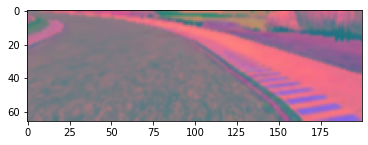

In [71]:
plt.imshow(X_test[np.random.randint(0,len(X_test)-1)])
print(X_test.shape)

In [72]:
def nvidia_model():
  model=Sequential()
  model.add(Conv2D(24,(5,5),strides=(2,2),input_shape=(66,200,3),activation='elu'))
  model.add(Conv2D(36,(5,5),strides=(2,2),activation='elu'))
  model.add(Conv2D(48,(5,5),strides=(2,2),activation='elu'))
  model.add(Conv2D(64,(3,3),activation='elu'))
  
  model.add(Conv2D(64,(3,3),activation='elu'))
  model.add(Dropout(.5))

  model.add(Flatten())

  model.add(Dense(100,activation='elu'))
  model.add(Dropout(.5))
  
  model.add(Dense(50,activation='elu'))
  model.add(Dropout(.5))

  model.add(Dense(10,activation='elu'))
  model.add(Dropout(.5))
  
  model.add(Dense(1))

  model.compile(Adam(learning_rate=1e-3),loss='mse',metrics=['accuracy'])
  return model

In [73]:
model=nvidia_model()
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 1, 18, 64)         36928     
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 18, 64)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1152)             

In [74]:
history=model.fit(X_train,y_train,batch_size=100,epochs=30,validation_data=(X_test,y_test))

Train on 1010 samples, validate on 253 samples
Epoch 1/30
1010/1010 [==============================] - 1s 1ms/step - loss: 0.4680 - accuracy: 0.1040 - val_loss: 0.1163 - val_accuracy: 0.1779
Epoch 2/30
1010/1010 [==============================] - 1s 701us/step - loss: 0.2116 - accuracy: 0.1465 - val_loss: 0.1094 - val_accuracy: 0.1779
Epoch 3/30
1010/1010 [==============================] - 1s 687us/step - loss: 0.1535 - accuracy: 0.1455 - val_loss: 0.0995 - val_accuracy: 0.1779
Epoch 4/30
1010/1010 [==============================] - 1s 659us/step - loss: 0.1348 - accuracy: 0.1485 - val_loss: 0.0958 - val_accuracy: 0.1779
Epoch 5/30
1010/1010 [==============================] - 1s 659us/step - loss: 0.1305 - accuracy: 0.1485 - val_loss: 0.0887 - val_accuracy: 0.1779
Epoch 6/30
1010/1010 [==============================] - 1s 669us/step - loss: 0.1205 - accuracy: 0.1545 - val_loss: 0.0867 - val_accuracy: 0.1779
Epoch 7/30
1010/1010 [==============================] - 1s 666us/step - loss: 0

In [78]:
def plotModelHistory(param1,param2):
  plt.plot(history.history[param1])
  plt.plot(history.history[param2])

  plt.xlabel('epochs')
  plt.legend([param1,param2])

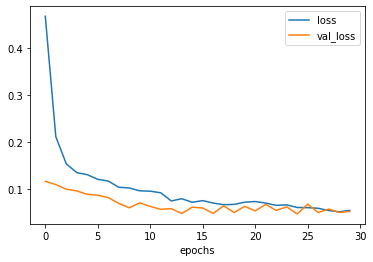

In [79]:
plotModelHistory('loss','val_loss')

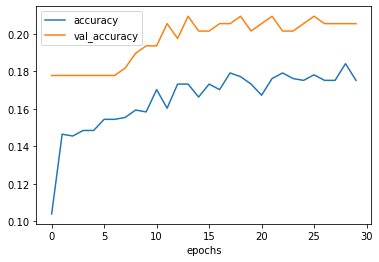

In [80]:
plotModelHistory('accuracy','val_accuracy')

In [81]:
model.save('selfDrivingCarmodel.h5')

In [82]:
from google.colab import files
files.download('selfDrivingCarmodel.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>